# An example where a conventional RNN fails, due to a lack of symmetry

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sys
from os import path
from keras.utils.np_utils import to_categorical   

Using TensorFlow backend.


## Simulate Data
$m$ sequences each of length $\ell$ and binary class $y$.  
class $y\sim \text{Bernoulli}(0.5)$  

$$x=(x_1,\ldots, x_\ell)$$
$x_i \sim \text{Bernoulli}(0.5)$ (iid)
Falls $y_i=1$, setze
$$x[t..t+10) \leftarrow 1$$

In [2]:
ell = 100
m = 5000
siglen = 10
s=2 # alphabet size

In [3]:
np.random.seed(13)

# development test data
def simulate_data(m, t, oneHot=True, standardize=False):
    x = np.random.randint(2, size = m*ell).reshape(m, ell)
    y = np.random.randint(2, size = m)
    for i in range(m):
        if y[i]:
            x[i, t:t + siglen] = 1
    if oneHot:
        x = to_categorical(x, num_classes=2)
    if standardize: # is better for SimpleRNN, oneHot or not
        x = x - 0.5 # standardize
    return x, y

## Obtain the training set

In [4]:
regenerate = True
fname = "rnn-fail-data.npz"

if regenerate or not path.exists(fname):
    # simulate new data
    x, y = simulate_data(3, t=20)
    np.savez(fname, x=x, y=y)

In [5]:
npzfile = np.load(fname)
x = npzfile['x']
y = npzfile['y']
print ("y", y, "\nx", x.shape, x[0,0:10,:])

y [1 1 1] 
x (3, 100, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


## Build the Model

In [6]:
from HMMCell import HMMCell, HMMLayer, TransitionMatrixChainInitializer

In [7]:
ini = TransitionMatrixChainInitializer(2.0)
ini([2,4,4])

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[2., 2., 0., 0.],
        [2., 2., 2., 0.],
        [0., 2., 2., 2.],
        [0., 0., 2., 2.]],

       [[2., 2., 0., 0.],
        [2., 2., 2., 0.],
        [0., 2., 2., 2.],
        [0., 0., 2., 2.]]], dtype=float32)>

In [8]:
seqLayer = HMMLayer(2, 11)
seqLayer(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.2230873e-04,  5.6546926e-04],
       [ 1.0496378e-04,  2.0343065e-03],
       [ 5.2571297e-05, -1.9788742e-05]], dtype=float32)>

In [9]:
def get_model(bidirectional = False, seqModelType = "SimpleRNN", RNNunits = 32):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(None,s)))

    if seqModelType == "HMM":
        seqLayer = HMMLayer(10, 15) # (10,15) is better than (5,11)
    elif seqModelType == "LSTM":
        seqLayer = layers.LSTM(RNNunits)
    elif seqModelType == "GRU":
        seqLayer = layers.GRU(RNNunits)
    elif seqModelType == "SimpleRNN":
        seqLayer = layers.SimpleRNN(RNNunits)
    else:
        sys.exit("unknown sequence model type " + seqModelType)

    if bidirectional:
        seqLayer = layers.Bidirectional(seqLayer)
    
    model.add(seqLayer)
    model.add(layers.Dense(1))
    lr = 1e-3
    #if seqModelType == "HMM":
    #    lr = 1e-2
    print (f"lr={lr}")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])
    return model

In [10]:
model = get_model(bidirectional = False, seqModelType = "SimpleRNN", RNNunits = 32)
model.summary()
model = get_model(bidirectional = False, seqModelType = "HMM")
model(x)
model.summary()
W = model.get_layer(index=0).C
W.print_pars()

lr=0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
lr=0.001
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hmm_layer_1 (HMMLayer)       (None, 10)                2700      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,711
Trainable params: 2,711
Non-trainable params: 0
_________________________________________________________________
transition m

## Ad hoc fixed prediction method
$$ \hat{y} = 1 :\Leftrightarrow \exists j: x[j..j+10) = 1$$

In [11]:
def adhoc_pred(x):
    x = np.squeeze(x+.5).astype('int')
    A = np.cumsum(x, axis=1)
    B = np.zeros_like(A)
    B[:,siglen:] = A[:,:-siglen]
    yhat = np.any(A-B >= siglen, axis=1).astype('int')
    return yhat

In [12]:
def adhoc_acc(x_test, y_test):
    yhat = adhoc_pred(x_test)
    correct = (yhat == y_test).astype('int')
    return correct.mean()

## Train the Model

In [13]:
from time import time

# ts = np.array(range(ell - 15, -1, -10))
ts = np.array(range(ell - 15, 20, -20))

len(ts)

4

In [14]:
num_reps = 8 # 30
num_epochs = 40 # 100
modelnames = ["HMM", "SimpleRNN", "LSTM", "GRU"] #, "ad hoc"]
directions = [False] # , True] # bidirectional?
test_accs = { (name, direction) : np.empty((len(ts), num_reps)) for name in modelnames for direction in directions}

for modelname in modelnames:
    start_time = time()
    for direction in directions:
        print (modelname, "dir=", direction, "\t", end = "")
        for j in range(len(ts)):
            t = ts[j]
            accs = test_accs[(modelname, direction)]
            for r in range(num_reps):
                accuracy = 0.0
                x_test, y_test = simulate_data(1000, t)
                if modelname == "ad hoc":
                    accuracy = adhoc_acc(x_test, y_test)
                else:
                    model = get_model(bidirectional = direction, seqModelType = modelname, RNNunits = 32)
                    x_train, y_train = simulate_data(m, t)
                    x_val, y_val = simulate_data(100, t)
                    # model.get_layer(index=0).C.print_pars()
                    model.fit(x_train, y_train,
                          validation_data = (x_val, y_val), batch_size = 16, epochs = num_epochs,
                              verbose=1 if modelname=="HMM" else 0)
                    if modelname == "HMM":
                        # print transition and emission matrices
                        pass
                        # model.get_layer(index=0).C.print_pars()
                    results = model.evaluate(x_test, y_test, batch_size = 16, verbose=0)
                    print ("j=", j, "\tt=", t, "\tr=", r, "\tresults=", results)
                    accuracy = results[1]
                accs[j, r] = accuracy
        print ("\n", accs)
    end_time = time()
    seconds_elapsed = end_time - start_time
    print ("time [s]:", seconds_elapsed)

HMM dir= False 	lr=0.001
Epoch 1/40
313/313 [==============================] - 14s 39ms/step - loss: 2.4376 - accuracy: 0.5000 - val_loss: 2.0581 - val_accuracy: 0.4100
Epoch 2/40
313/313 [==============================] - 15s 46ms/step - loss: 1.6499 - accuracy: 0.5076 - val_loss: 1.5749 - val_accuracy: 0.4100
Epoch 3/40
313/313 [==============================] - 15s 49ms/step - loss: 1.1238 - accuracy: 0.5004 - val_loss: 0.8417 - val_accuracy: 0.4600
Epoch 4/40
313/313 [==============================] - 15s 48ms/step - loss: 0.7252 - accuracy: 0.5928 - val_loss: 0.6676 - val_accuracy: 0.6300
Epoch 5/40
313/313 [==============================] - 15s 48ms/step - loss: 0.6668 - accuracy: 0.7021 - val_loss: 0.6438 - val_accuracy: 0.7400
Epoch 6/40
313/313 [==============================] - 18s 56ms/step - loss: 0.6762 - accuracy: 0.6885 - val_loss: 0.6415 - val_accuracy: 0.7200
Epoch 7/40
313/313 [==============================] - 18s 59ms/step - loss: 0.6670 - accuracy: 0.7046 - val_los

## Plot Results

Accuracy was averaged over 8 repetitions


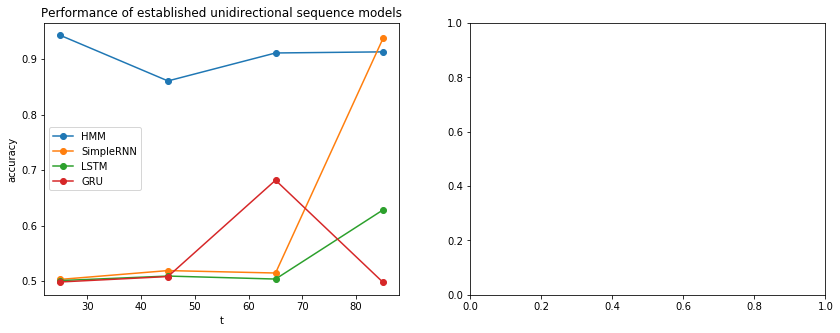

In [15]:
#  single plot
somemodelnames = ["HMM", "SimpleRNN", "LSTM", "GRU"] #["SimpleRNN", "LSTM", "GRU", "ad hoc"]
fig, ax = plt.subplots(1,2, figsize=(14, 5))
for j, direction in enumerate(directions):
    for i, model in enumerate(somemodelnames):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[j].plot(ts, avg_test_acc, 'o-', label = model)
    ax[j].set_title('Performance of established ' + ("bidirectional" if direction else "unidirectional") + " sequence models" )
    ax[j].set_xlabel("t")
    ax[j].set_ylabel("accuracy");
    ax[j].legend()
print ('Accuracy was averaged over ' + str(num_reps) + ' repetitions')
fig.savefig('failing1.pdf') 

In [16]:
modelnames

['HMM', 'SimpleRNN', 'LSTM', 'GRU']

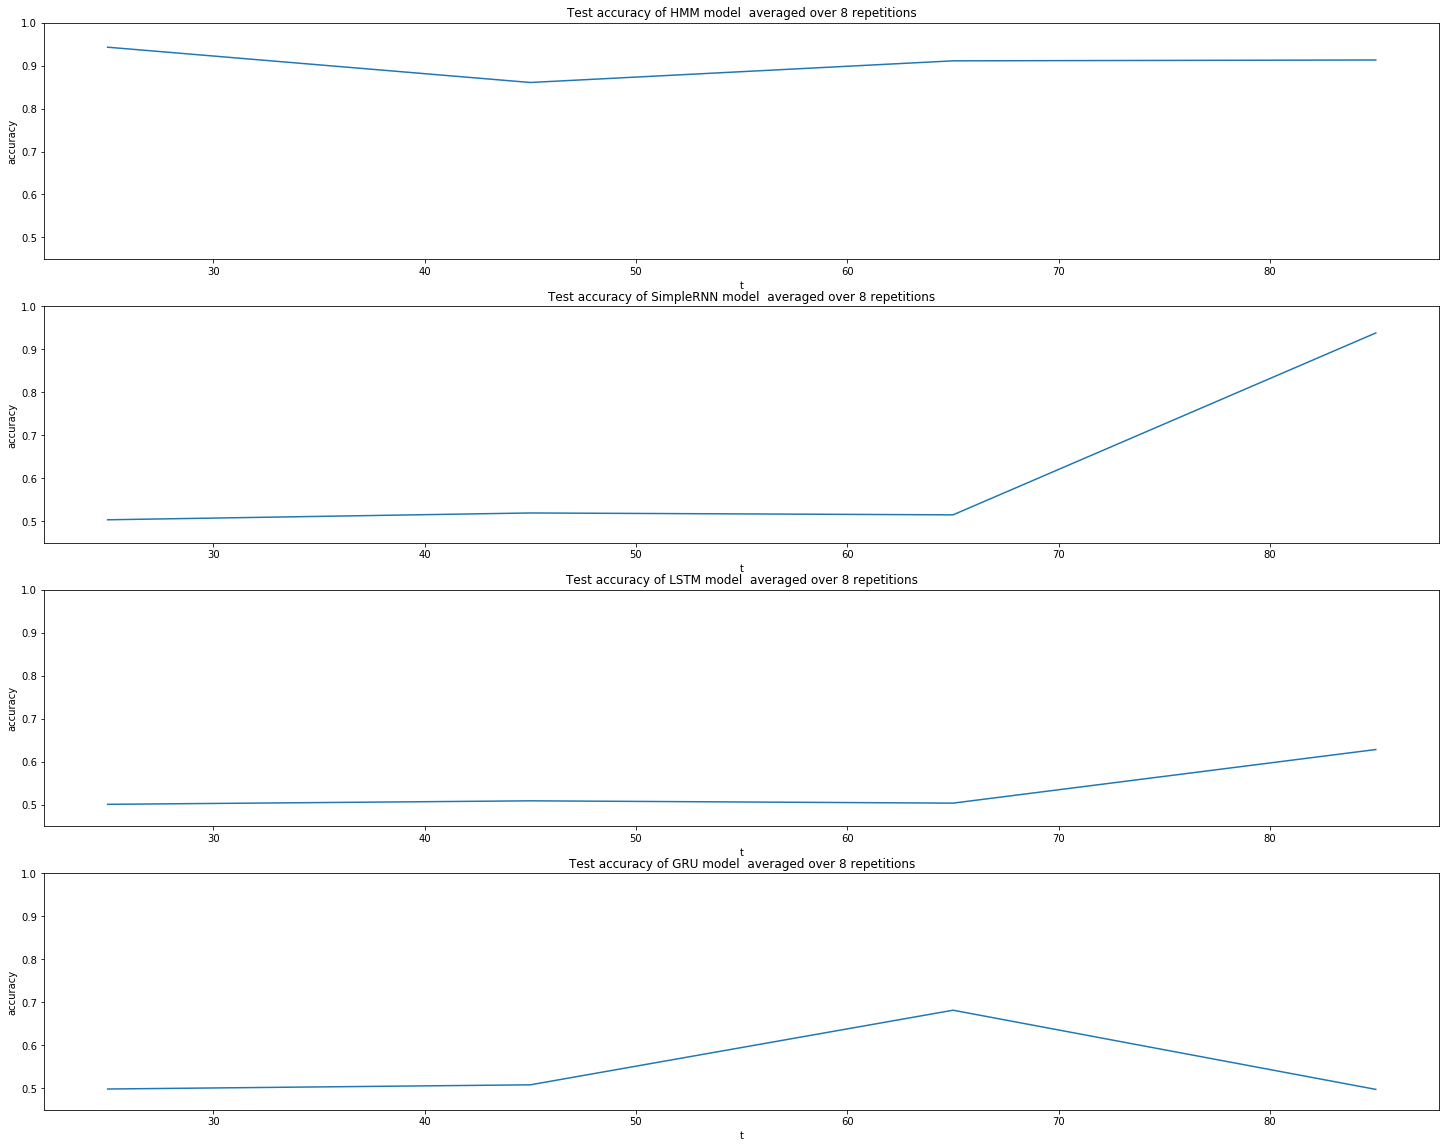

In [17]:
# one plot each
fig, ax = plt.subplots(len(modelnames), len(directions), squeeze=False, figsize=(25,20))
for i, model in enumerate(modelnames):
    for j, direction in enumerate(directions):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[i,j].plot(ts, avg_test_acc)
        ax[i,j].set_ylim([.45, 1])
        ax[i,j].set_title('Test accuracy of ' + model + ' model ' + ("(Bidirectional)" if direction else "") + ' averaged over ' + str(num_reps) + ' repetitions')
        ax[i,j].set_xlabel("t")
        ax[i,j].set_ylabel("accuracy");

In [18]:
fig.savefig('failing.pdf') 